In [1]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 4

# <center>Tarea 2 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

2 de Noviembre de 2017
</center>



# Introducción

Este trabajo tratará sobre la generación de modelos de clasificación para tres problemas distintos, utilizando los siguientes métodos lineales: PCA (Principal Component Analysis), LDA (Linear Discriminant Analysis), QDA (Quadratic Discriminant Analysis), k-NN (k Nearest Neighbours), Naive Bayes, SVMs (Support Vector Machines) y Logistic Regression.

# 1. Identificación de sonidos fonéticos

## a) Ingreso de los datos

Se comenzará con la carga de los conjuntos de entrenamiento y de prueba de sonidos fonéticos del inglés británico.

In [2]:
train_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train"
test_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test"
train_data_f = urllib.request.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.request.urlretrieve(test_data_url, "test_data.csv")
train_df = pd.DataFrame.from_csv('train_data.csv',header=0,index_col=0)
test_df = pd.DataFrame.from_csv('test_data.csv',header=0,index_col=0)

In [61]:
train_df.head()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


In [4]:
test_df.tail()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
458,7,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147
459,8,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301
460,9,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500
461,10,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390
462,11,-3.291,2.324,-0.679,0.285,0.441,0.557,-0.227,0.115,-1.046,0.697


In [5]:
print("El conjunto de entrenamiento tiene", train_df.shape[0], "registros")

El conjunto de entrenamiento tiene 528 registros


In [6]:
print("El conjunto de entrenamiento tiene", test_df.shape[0], "registros")

El conjunto de entrenamiento tiene 462 registros


Podemos ver que este *dataset* sólo indica 10 características para cada dato. Cada valor en las características es un número real, y las salidas son números enteros. Es necesario revisar cómo se distribuyen estas salidas.

In [7]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

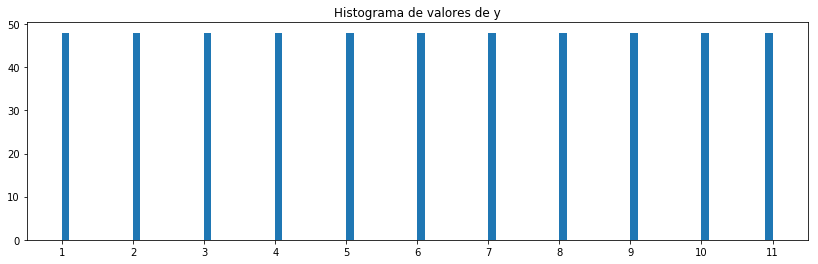

In [63]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.xticks(range(1,12))
plt.hist(train_df.y,bins=100)
plt.show()

In [9]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

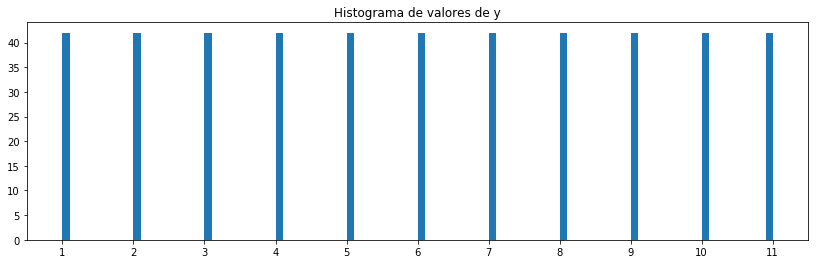

In [64]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.xticks(range(1,12))
plt.hist(test_df.y,bins=100)
plt.show()

En ambos datasets (entrenamiento y prueba) las salidas son parte del conjunto de números enteros $[1,11]$, y se tiene un número igual de casos para cada posible salida, por lo tanto, podemos decir que las clases de los datasets están bien balanceados.

## b) Tranformación de los datos: Normalización

Antes de aplicar técnicas de reducción de dimensionalidad, los datos de cada característica se estandarizarán utilizando **StandardScaler**, la cual transforma los valores restándole el promedio y dividiendo por la desviación estándar (de cada variable o característica). Esto hace que los datos de cada variable tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

In [65]:
from sklearn.preprocessing import StandardScaler
X = train_df.loc[:,'x.1':'x.10'].values
y = train_df.loc[:,'y'].values
Scaler = StandardScaler().fit(X)
X_std = Scaler.transform(X)

## c), d) y e) Tranformación de los datos: Reducción a 2 dimensiones mediante PCA y LDA

A continuación, se utilizará PCA (*Principal Component Analysis*) para proyectar cada uno de los datos de entrenamiento en tan sólo dos dimensiones (que para PCA, serán los vectores con direcciones de mayor varianza), y luego se hará un coloreo de cada uno de los datos en esta proyección según la clase *target* a la que pertenecen (o sea, entre 1 y 11). Se dice que PCA es un clasificador no supervisado, ya que no requiere que los datos de entrenamiento estén ya clasificados (con *labels*).

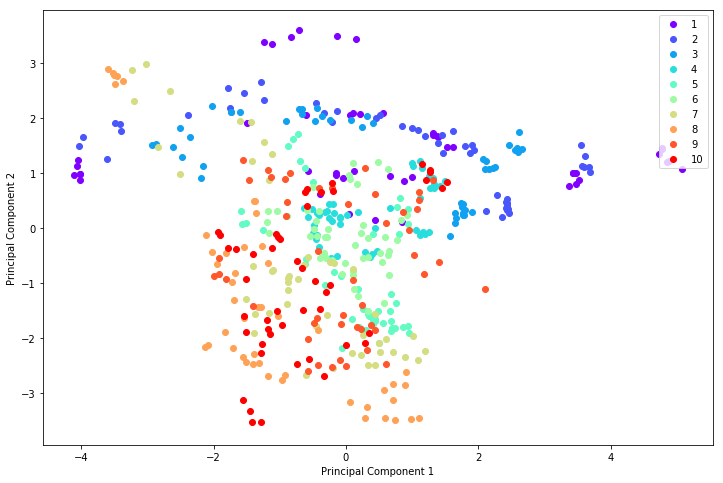

In [66]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sklearn_pca = PCA(n_components=2)
Xred_pca = sklearn_pca.fit_transform(X_std)
cmap = plt.cm.get_cmap("rainbow")
mclasses=(1,2,3,4,5,6,7,8,9,10)
mcolors = [cmap(i) for i in np.linspace(0,1,10)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_pca[y==lab, 0],Xred_pca[y==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

Podemos ver que PCA logra proyectar los datos de entrenamiento en las dos dimensiones, pero al ver sus *labels* o las clases a las que pertenecen, nos damos cuenta que no se produce una buena separación de éstas. Por lo tanto, si más adelante queremos hacer un clasificador con estos datos transformados, se nos será muy difícil obtener buenos resultados.

Ahora se realizará el mismo ejercicio, pero utilizando LDA (*Linear Discriminant Analysis*). Este método se basa a grandes rasgos a encontrar el hiperplano (o subespacios con frontera de decisión lineal, en casos de más de 2 clases) que separa de mejor manera a las clases existentes. Utiliza como supuesto que los datos pertencientes a cada clase tienen una distribución normal, y que la covarianza entre clases es siempre la misma (matrices de covarianza iguales). Se dice que es un clasificador supervisado, ya que utiliza los *labels* que identifican a los datos de entrenamiento en alguna clase (en este caso, los valores de $y$ para cada fila del *dataset*)

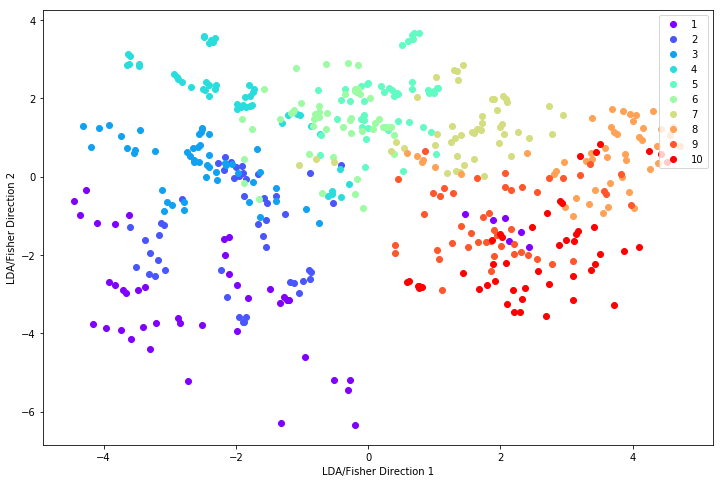

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_lda = LDA(n_components=2)
Xred_lda = sklearn_lda.fit_transform(X_std,y)
cmap = plt.cm.get_cmap("rainbow")
mclasses=(1,2,3,4,5,6,7,8,9,10)
mcolors = [cmap(i) for i in np.linspace(0,1,10)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_lda[y==lab, 0],Xred_lda[y==lab, 1],label=lab,c=col)
plt.xlabel('LDA/Fisher Direction 1')
plt.ylabel('LDA/Fisher Direction 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

Podemos ver que LDA logra separar las clases de mejor manera, y por lo tanto, utilizando sólo estas dos dimensiones podremos crear un clasificador que asigne nuevos datos de prueba en forma relativamente correcta. Vale mencionar que, a pesar de tener una major proyección que PCA, aún existen problemas con outliers y espacios donde las clases comparten elementos de prueba, en especial el caso donde el espacio de las clases 8 y 9 tiene elementos de la clase 1.

## f) Clasificador aleatorio a-priori

A continuación se implementa un clasificador que simplemente elige una clase aleatoriamente, según la probabilidad de cada clase en el conjunto de entrenamiento. Citando el enunciado del problema: "Por ejemplo, si la clase y = 0 ocurre
el 25% de las veces, el clasificador debe predecir esta clase para un determinado x con probabilidad
0.25, independiente de los atributos de x."

In [15]:
from collections import Counter
Counter(y)
y.shape[0]

list(set(y))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Error de clasificador aleatorio a-priori es 1.0
0.0738636363636
0.926136363636


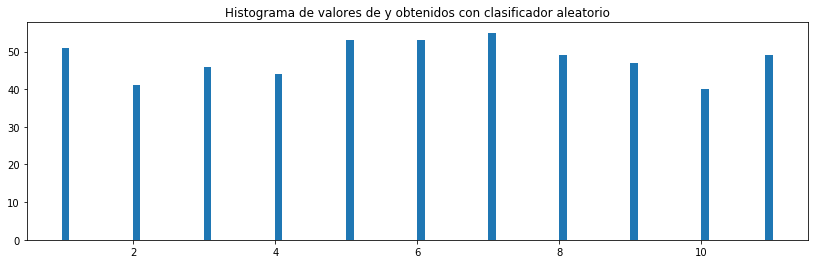

In [109]:
import random
from sklearn.metrics import accuracy_score as accuracy_score

#print(random.__file__)

def get_probabilities(y):
    sum = y.shape[0]
    y_set = list(set(y))
    y_probabilities = []
    for i in y_set:
        y_probabilities.append( (list(y).count(i))/sum )
    return y_probabilities


def random_classifier(X,y):
    y_probabilities = get_probabilities(y)
    y_pred = random.choices(list(set(y)), weights=y_probabilities, k=y.shape[0])
    return y_pred

#Error de clasificacion
def get_error(yhat, ytest):
    total_error = 0
    for i in yhat:
        if yhat[i] != ytest[i]:
            total_error = total_error + 1
    return total_error / len(yhat)

y_random = random_classifier(X_std,y)

print("Error de clasificador aleatorio a-priori es", get_error(y_random, y))
print(accuracy_score(y_random, y))
print(1-accuracy_score(y_random, y))

plt.title("Histograma de valores de y obtenidos con clasificador aleatorio")
plt.hist(y_random,bins=100)
plt.show()

Vemos que claramente, al tener 11 clases posibles y datos de entrenamiento bien balanceados, el clasificador aleatorio a-priori tiene un mal rendimiento, que además es difícil de predecir.

## g) Clasificación sin reducción de dimensionalidad: LDA, QDA y k-Nearest Neighbours

Un trabajo común es utilizar PCA o LDA para la reducción de dimensionalidad de un conjunto de datos, para luego poder aplicar otro algoritmo y generar un clasificador. Sin embargo, nuestro conjunto de datos tiene sólo 10 características, por lo que es posible que no se necesite hacer reducción de dimensionalidad.

A continuación se utilizarán tres algoritmos para generar clasificadores:

* LDA (Linear Discriminant Analysis), el cual ya utilizamos anteriormente
* QDA (Quadratic Discriminant Analysis), el cual es una generalización de LDA que no asume que la covarianza entre clases es igual, y por lo tanto, requiere además estimar estas covarianzas. Sin embargo, es capaz de generar fronteras de decisión cuadráticas, que pueden tener un mejor desempeño que las de LDA.
* KNN (k-Nearest Neighbours) es un algoritmo de clasificación simple, que a cada nuevo dato de prueba le asigna la clase mayoritaria de los $k$ vecinos más cercanos en el espacio. Por lo tanto, la estructura de datos simplemente guarda los datos de entrenamiento y no se hace computación hasta que ocurre la clasificación.

El parámetro k para KNN será probado en el conjunto entero $k \in [1,..,50]$, y se utilizará el valor de k que tenga mejor desempeño con el conjunto de prueba.

Vale mencionar que el *score* o puntaje con que se evalúan estos clasificadores es simplemente el porcentaje de elementos del conjunto de prueba que fueron clasificados correctamente (siendo $0$ si ninguno fue bien clasificado, $1$ si todos fueron bien clasificados, $0.5$ si la mitad de los datos fueron bien clasificados, etc.)

-----LDA-----
Score with training set: 0.683712121212
Score with testing set: 0.443722943723
-----QDA-----
Score with training set: 0.988636363636
Score with testing set: 0.471861471861
-----KNN-----
Best score with training set: 1.0 , using k = 1
Best score with testing set: 0.519480519481 , using k = 7


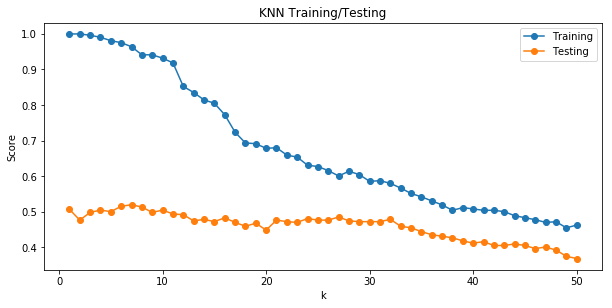

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
Xtest = test_df.loc[:,'x.1':'x.10'].values
ytest = test_df.loc[:,'y'].values
X_std_test = Scaler.transform(Xtest)


lda_model = LDA()
lda_model.fit(X_std,y)
print("-----LDA-----")
print("Score with training set:", lda_model.score(X_std,y))
print("Score with testing set:", lda_model.score(X_std_test,ytest))


qda_model = QDA()
qda_model.fit(X_std,y)
print("-----QDA-----")
print("Score with training set:", qda_model.score(X_std,y))
print("Score with testing set:", qda_model.score(X_std_test,ytest))


print("-----KNN-----")
knn_scores_training = []
knn_scores_testing = []
k = range(1,51)
for c in k:
    knn_model = KNeighborsClassifier(n_neighbors=c)
    knn_model.fit(X_std,y)
    knn_scores_training.append(knn_model.score(X_std,y))
    knn_scores_testing.append(knn_model.score(X_std_test,ytest))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("k")
plt.ylabel("Score")
#plt.xticks(range(1,50))
plt.title("KNN Training/Testing")
plt.plot(k,knn_scores_training, '-o',k,knn_scores_testing, '-o')
plt.legend(("Training", "Testing"), loc = "upper right")

knn_max_training = max(knn_scores_training)
knn_max_training_index = knn_scores_training.index(knn_max_training)
knn_max_testing = max(knn_scores_testing)
knn_max_testing_index = knn_scores_testing.index(knn_max_testing)
print("Best score with training set:", knn_max_training, ", using k =",knn_max_training_index+1)
print("Best score with testing set:", knn_max_testing, ", using k =",knn_max_testing_index+1)

plt.show()

In [68]:
knn_max = max(knn_scores_testing)
knn_max_index = knn_scores_testing.index(knn_max)
print("Mejor score en conjunto de prueba es", knn_max, ", con k =",knn_max_index+1)

Mejor score en conjunto de prueba es 0.519480519481 , con k = 7


Finalmente con KNN y el parámetro $k=7$ obtuvimos el mejor desempeño del conjunto de prueba, el cual es de $0.5194$. Esto puede dar la idea que un algoritmo simple como KNN va a ser el mejor, sin embargo, no todos los problemas van a permitir utilziar este algoritmo: el uso de memoria de KNN y el tiempo de computación para cada clasificación puede ser prohibitivo con *datasets* grandes.

## h) Clasificación con reducción de dimensionalidad usando PCA: LDA, QDA y k-Nearest Neighbours

A continuación se harán los dos pasos explicados anteriormente: se hará una reducción de dimensionalidad (desde 1 hasta 10 dimensiones, $d' \in [1,10]$) y para cada caso se aplicará LDA, QDA y KNN. Se verá el error en el conjunto de entrenamiento y del conjunto de prueba para cada valor de $d'$, utilizando error de clasificación (porcentaje de clasificaciones incorrectas).

In [84]:
#Error de clasificacion
def get_error(yhat, ytest):
    total_error = 0
    for i in yhat:
        if yhat[i] != ytest[i]:
            total_error = total_error + 1
    return total_error / len(yhat)

X_pca_array = []
lda_scores_training = []
lda_scores_testing = []
qda_scores_training = []
qda_scores_testing = []
knn_best_scores_training = []
knn_best_scores_testing = []

lda_err_training = []
lda_err_testing = []
qda_err_training = []
qda_err_testing = []
knn_best_err_training = []
knn_best_err_testing = []


for i in range(1,11):
    print("\n", "d' =", i,"\n")
    
    #Se reduce la dimensionalidad con PCA
    sklearn_pca_temp = PCA(n_components=i)
    pca_model_temp = sklearn_pca_temp.fit(X_std)
    X_pca_train_temp = pca_model_temp.transform(X_std)
    X_pca_test_temp = pca_model_temp.transform(X_std_test)
    
    
    # Caso 1: LDA
    lda_model = LDA()
    lda_model.fit(X_pca_train_temp,y)
    
    # Se calcula score y error de LDA
    lda_scores_training.append(lda_model.score(X_pca_train_temp,y))
    lda_scores_testing.append(lda_model.score(X_pca_test_temp,ytest))
    print("LDA => Score with training set:", lda_scores_training[-1], ", Score with testing set:", lda_scores_testing[-1])
    yhat_training = lda_model.predict(X_pca_train_temp)
    yhat_testing = lda_model.predict(X_pca_test_temp)
    lda_err_training.append(get_error(yhat_training, y))
    lda_err_testing.append(get_error(yhat_testing, ytest))
    
    # Caso 2: QDA
    qda_model = QDA()
    qda_model.fit(X_pca_train_temp,y)
    
    # Se calcula score y error de QDA
    qda_scores_training.append(qda_model.score(X_pca_train_temp,y))
    qda_scores_testing.append(qda_model.score(X_pca_test_temp,ytest))
    print("QDA => Score with training set:", qda_scores_training[-1], ", Score with testing set:", qda_scores_testing[-1])
    yhat_training = qda_model.predict(X_pca_train_temp)
    yhat_testing = qda_model.predict(X_pca_test_temp)
    qda_err_training.append(get_error(yhat_training, y))
    qda_err_testing.append(get_error(yhat_testing, ytest))
    
    # Caso 2: KNN
    knn_scores_training = []
    knn_scores_testing = []
    knn_err_training = []
    knn_err_testing = []
    k = range(1,51)
    # Se prueba con k entre 1 y 50
    for c in k:
        knn_model = KNeighborsClassifier(n_neighbors=c)
        knn_model.fit(X_pca_train_temp,y)
        knn_scores_training.append(knn_model.score(X_pca_train_temp,y))
        knn_scores_testing.append(knn_model.score(X_pca_test_temp,ytest))
        knn_err_training.append(get_error(knn_model.predict(X_pca_train_temp), y))
        knn_err_testing.append(get_error(knn_model.predict(X_pca_test_temp), ytest))
        

    # Se obtiene el k con mejor score
    knn_max_testing = max(knn_scores_testing)
    knn_max_testing_index = knn_scores_testing.index(knn_max_testing)
    
    # Se calcula score y error de KNN usando el k con menor error de prueba
    knn_best_scores_training.append(knn_scores_training[knn_max_testing_index])
    knn_best_scores_testing.append(knn_max_testing)
    print("KNN => Score with training set:", knn_best_scores_training[-1], ", Score with testing set:", knn_best_scores_testing[-1])
    print("Best k for the testing set is", knn_max_testing_index+1)
    knn_best_err_training.append(knn_err_training[knn_max_testing_index+1])
    knn_best_err_testing.append(knn_err_testing[knn_max_testing_index+1])
    


 d' = 1 

LDA => Score with training set: 0.181818181818 , Score with testing set: 0.134199134199
QDA => Score with training set: 0.238636363636 , Score with testing set: 0.160173160173
KNN => Score with training set: 0.363636363636 , Score with testing set: 0.175324675325
Best k for the testing set is 15

 d' = 2 

LDA => Score with training set: 0.287878787879 , Score with testing set: 0.253246753247
QDA => Score with training set: 0.325757575758 , Score with testing set: 0.248917748918
KNN => Score with training set: 0.585227272727 , Score with testing set: 0.257575757576
Best k for the testing set is 13

 d' = 3 

LDA => Score with training set: 0.371212121212 , Score with testing set: 0.290043290043
QDA => Score with training set: 0.566287878788 , Score with testing set: 0.285714285714
KNN => Score with training set: 1.0 , Score with testing set: 0.387445887446
Best k for the testing set is 1

 d' = 4 

LDA => Score with training set: 0.477272727273 , Score with testing set: 0.36

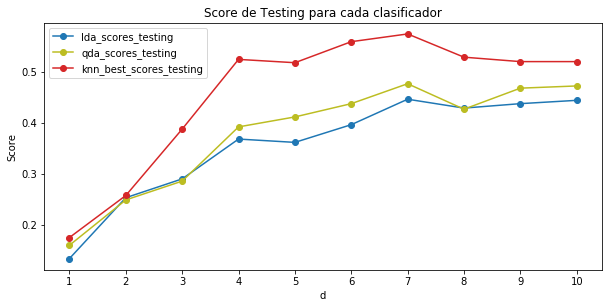

In [85]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Score")
plt.title("Score de Testing para cada clasificador")
plt.plot(d,lda_scores_testing, '-o', label='lda_scores_testing', color='tab:blue')
plt.plot(d,qda_scores_testing, '-o', label='qda_scores_testing', color='tab:olive')
plt.plot(d,knn_best_scores_testing, '-o', label='knn_best_scores_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

En el conjunto de pruebas, El mejor resultado fué obtenido con $d' = 7$ dimensiones y KNN con $k = 2$, con un score de $0.573593073593$. Quizás además sea necesario ver los puntajes en el conjunto de entrenamiento.

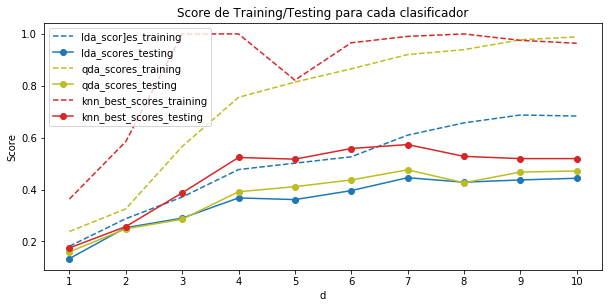

In [86]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Score")
plt.title("Score de Training/Testing para cada clasificador")
plt.plot(d,lda_scores_training, '--', label='lda_scor]es_training', color='tab:blue')
plt.plot(d,lda_scores_testing, '-o', label='lda_scores_testing', color='tab:blue')
plt.plot(d,qda_scores_training, '--', label='qda_scores_training', color='tab:olive')
plt.plot(d,qda_scores_testing, '-o', label='qda_scores_testing', color='tab:olive')
plt.plot(d,knn_best_scores_training, '--', label='knn_best_scores_training', color='tab:red')
plt.plot(d,knn_best_scores_testing, '-o', label='knn_best_scores_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

Vemos que en general KNN y QDA tienen buen puntaje en el conjunto de entrenamiento al usar $3$ o más dimensiones, pero más allá de $7$ dimensiones el puntaje se estanca o baja para los datos de prueba. Por lo tanto, tendremos 7 dimensiones como el mejor valor.

Finalmente se mostrarán gráficos similares, pero con el error de clasificación.

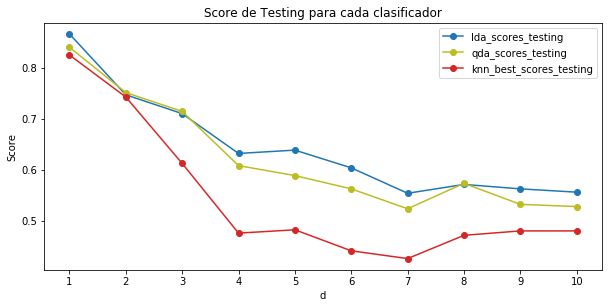

In [91]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Score")
plt.title("Score de Testing para cada clasificador")
plt.plot(d, np.ones(len(lda_scores_testing)) - lda_scores_testing, '-o', label='lda_scores_testing', color='tab:blue')
plt.plot(d, np.ones(len(qda_scores_testing)) - qda_scores_testing, '-o', label='qda_scores_testing', color='tab:olive')
plt.plot(d, np.ones(len(knn_best_scores_testing)) - knn_best_scores_testing, '-o', label='knn_best_scores_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

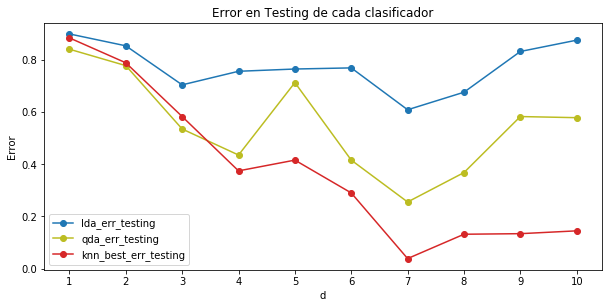

In [87]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Error")
plt.title("Error en Testing de cada clasificador")
plt.plot(d,lda_err_testing, '-o', label='lda_err_testing', color='tab:blue')
plt.plot(d,qda_err_testing, '-o', label='qda_err_testing', color='tab:olive')
plt.plot(d,knn_best_err_testing, '-o', label='knn_best_err_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

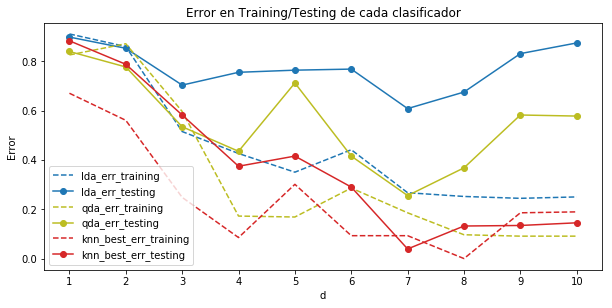

In [88]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Error")
plt.title("Error en Training/Testing de cada clasificador")
plt.plot(d,lda_err_training, '--', label='lda_err_training', color='tab:blue')
plt.plot(d,lda_err_testing, '-o', label='lda_err_testing', color='tab:blue')
plt.plot(d,qda_err_training, '--', label='qda_err_training', color='tab:olive')
plt.plot(d,qda_err_testing, '-o', label='qda_err_testing', color='tab:olive')
plt.plot(d,knn_best_err_training, '--', label='knn_best_err_training', color='tab:red')
plt.plot(d,knn_best_err_testing, '-o', label='knn_best_err_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

In [ ]:
Podemos ver un comportamiento bastante similar

# 2. Análisis de Opiniones sobre Películas

El análisis de sentimiento (o minerı́a de opiniones) se refiere al proceso de extraer información acerca de
la actitud que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con
respecto a un tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar
la polaridad de un trozo de texto, es decir, clasificar una determinada evaluación escrita (ó review ), en que
una persona manifiesta una opinión, como positiva, negativa o neutral. La dificultad de este problema radica
en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas ası́ como el
manejo de negaciones, sarcasmo y abreviaciones en una frase.

### a . Construya un dataframe con los datos a analizar descargando los datos desde la URL local. Determine cuántos registros de cada clase contiene el conjunto de entrenamiento y cuántos el conjunto de pruebas

In [3]:
#Se contruye el data frame 
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.request.urlretrieve(train_data_url, "train_data_item2.csv")
test_data_f = urllib.request.urlretrieve(test_data_url, "test_data_item2.csv")
ftr = open("train_data_item2.csv", "r", errors='replace')
fts = open("test_data_item2.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])
print(train_df.shape)
print(test_df.shape)

(3554, 2)
(3554, 2)


In [4]:
print("El conjunto de entrenamiento tiene:",train_df.shape[0], "registros")
print("El conjunto de pruebas tiene:",test_df.shape[0], "registros")

El conjunto de entrenamiento tiene: 3554 registros
El conjunto de pruebas tiene: 3554 registros


Tenemos que la cantidad de clases estará dada por la columna "Sentiment" del dataset, donde existen dos valores posibles $+1$ para comentarios positivos y $-1$ para comentarios negativos.

In [5]:
count_train_df = pd.value_counts(train_df['Sentiment'].values, sort=False)
count_test_df = pd.value_counts(test_df['Sentiment'].values, sort=False)
print("---Conjunto de entrenamiento---")
print("La cantidad de elementos que tienen la clase +1 es: ",count_train_df[1])
print("La cantidad de elementos que tienen la clase -1 es: ",count_train_df[-1])
print("\n")
print("---Conjunto de prueba---")
print("La cantidad de elementos que tienen la clase +1 es: ",count_test_df[1])
print("La cantidad de elementos que tienen la clase -1 es: ",count_test_df[-1])

---Conjunto de entrenamiento---
La cantidad de elementos que tienen la clase +1 es:  1770
La cantidad de elementos que tienen la clase -1 es:  1784


---Conjunto de prueba---
La cantidad de elementos que tienen la clase +1 es:  1751
La cantidad de elementos que tienen la clase -1 es:  1803


### (b) Construya una función, denominada word extractor, que devuelva una lista de las palabras contenidas en un determinado un trozo de texto. Incorpore en su función las operaciones de lower-casing y stemming. Pruebe la función con las frases sugeridas en el código, invente otras similares y comente. Compare con los resultados obtenidos si no se hace stemming.

[algoritmo de Porter]

Este algoritmo asegura que la forma de las palabras no penalice la frecuencia de éstas. Es decir, una palabra puede estar conjugada en cualquier (género, número, persona, etc.) y solo se considerará (en muchas ocasiones) como un solo término.

https://stackoverflow.com/questions/28583565/str-object-has-no-attribute-decode-python-3-error

In [7]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor(text):
    ps = PorterStemmer()
    commonwords = stopwords.words('english')
    commonwords.remove("not")
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ ps.stem(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

def word_extractor_simple(text):
    ps = PorterStemmer()
    #Se eliminan las "palabras vacias"
    commonwords = stopwords.words('english')
    commonwords.remove("not")
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ word.lower() for word in word_tokenize(text) ]
    for word in wordtokens:
        #Se dejan solo las palabras relevantes
        if word not in commonwords:
            words+=" "+word
    return words

print(word_extractor("I love to eat cake"))
print(word_extractor("I love eating cake"))
print(word_extractor("I loved eating the cake"))
print(word_extractor("I do not love eating cake"))
print(word_extractor("I don't love eating cake"))

print(word_extractor("You awake late"))
print(word_extractor("You awoke late"))
print(word_extractor("You have been awaking late"))
print(word_extractor("I would have awaken"))

print(word_extractor("ask"))
print(word_extractor("asked"))

print("\n")
print(word_extractor_simple("I love to eat cake"))
print(word_extractor_simple("I love eating cake"))
print(word_extractor_simple("I loved eating the cake"))
print(word_extractor_simple("I do not love eating cake"))
print(word_extractor_simple("I don't love eating cake"))                     

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/home/victor/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

### (c) Construya una función, denominada word extractor2, análoga a la función anterior, pero que lematice las palabras en vez de hacer stemming. Pruebe la función con las frases sugeridas en el código anterior y discuta las diferencias que observa.


La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos.

In [83]:
def word_extractor2(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    commonwords.remove("not")
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

print(word_extractor2("I love to eat cake"))
print(word_extractor2("I love eating cake"))
print(word_extractor2("I loved eating the cake"))
print(word_extractor2("I do not love eating cake"))
print(word_extractor2("I don't love eating cake"))

print(word_extractor2("You awaked late"))
print(word_extractor2("You awoke late"))
print(word_extractor2("You have been awaking late"))
print(word_extractor2("I would have awaken"))

print(word_extractor2("aardwolves"))
print(word_extractor2("abaci"))
                      

 love eat cake
 love eating cake
 loved eating cake
 not love eating cake
 n't love eating cake
 awaked late
 awoke late
 awaking late
 would awaken
 aardwolf
 abacus


-Stemming algorithms work by cutting off the end of the word, and in some cases also the beginning while looking for the root. This indiscriminate cutting can be successful in some occasions, but not always, that is why we affirm that this an approach that offers some limitations.

-Lemmatization on the other hand takes into consideration the morphological analysis of the words. To do so it is necessary to have detailed dictionaries the algorithm can look back at to link the form back to its lemma. 

The main difference is that a lemma is the base form of all its inflectional forms. However, the stem can be the same for the inflectional forms of different lemmas, providing then noise to our search results.


### (d) Utilizando la función CountVectorizer de la librería sklearn y de acuerdo a las directrices mencionadasen la introducción, genere una representación vectorial del texto de entrenamiento y del conjunto que usaremos para realizar pruebas. Explore el vocabulario utilizado y determine cuáles son las palabras más frecuentes en el conjunto de entrenamiento y pruebas.

In [18]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tabulate  import tabulate

def vect_rep(train_df, test_df, v = "porter", v1 = "train"):
    if v == "porter":
        texts_train = [word_extractor(text) for text in train_df.Text]
        texts_test = [word_extractor(text) for text in test_df.Text]
    if v == "lem":
        texts_train = [word_extractor2(text) for text in train_df.Text]
        texts_test = [word_extractor2(text) for text in test_df.Text]
    vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
    vectorizer.fit(np.asarray(texts_train))
    features_train = vectorizer.transform(texts_train)
    features_test = vectorizer.transform(texts_test)
    labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
    labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
    vocab = vectorizer.get_feature_names()
    if v1 == "train":
        dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
        features = features_train
        labels = labels_train
    if v1 == "test":
        dist=list(np.array(features_test.sum(axis=0)).reshape(-1,))
        features = features_test
        labels = labels_test
    #Se modifica el codigo original para guardar cada tag y su frecuencia 
    frec_tag = []
    for tag, count in zip(vocab, dist):
        frec_tag.append([count, tag])
    return frec_tag,features,labels 

In [9]:
def n_more_frequent(l,n):
    # Se ordenan de manera descendente
    sorted_tags = sorted(l, reverse=True)
    # Se guardan las n palabras mas frecuentes
    elements = []
    for i in range(n):
        elements.append(sorted_tags[i])
    return elements

def tab(a,b,n):
    aa = n_more_frequent(a,n)
    bb = n_more_frequent(b,n)
    from tabulate import tabulate
    tab = []
    for i  in range(len(aa)):
        tab.append([aa[i],bb[i]])
    return tab   

In [26]:
a,features_train_porter,labels_train_porter = vect_rep(train_df, test_df, "porter","train")
b,features_train_lem,labels_train_lem = vect_rep(train_df, test_df, "lem","train")

In [28]:
c,features_test_porter,labels_test_porter = vect_rep(train_df, test_df, "porter","test")
d,features_test_lem,labels_test_lem = vect_rep(train_df, test_df, "lem","test")

In [16]:
n = 15

tab_train = tab(a,b,n)
tab_test = tab(c,d,n)
print("Las",n,"palabras mas frecuentes para el conjunto de entrenamiento")
print(tabulate(tab_train, headers=['PorterStemmer', 'wordlemmatizer']))
print("\n")
print("Las",n,"palabras mas frecuentes para el conjunto de prueba")
print(tabulate(tab_test, headers=['PorterStemmer', 'wordlemmatizer']))


Las 15 palabras mas frecuentes para el conjunto de entrenamiento
PorterStemmer     wordlemmatizer
----------------  ------------------
[575, 'film']     [567, 'film']
[477, 'movi']     [481, 'movie']
[425, 'thi']      [266, 'not']
[269, 'not']      [246, 'one']
[268, 'like']     [245, 'like']
[245, 'one']      [224, 'ha']
[224, 'ha']       [183, 'make']
[207, 'make']     [176, 'story']
[179, 'hi']       [163, 'character']
[176, 'stori']    [145, 'comedy']
[161, 'charact']  [143, 'time']
[148, 'time']     [143, 'even']
[144, 'good']     [141, 'good']
[144, 'even']     [128, 'much']
[142, 'comedi']   [127, 'doe']


Las 15 palabras mas frecuentes para el conjunto de prueba
PorterStemmer     wordlemmatizer
----------------  ------------------
[572, 'film']     [558, 'film']
[530, 'movi']     [541, 'movie']
[514, 'thi']      [278, 'not']
[281, 'not']      [250, 'one']
[250, 'one']      [238, 'ha']
[248, 'like']     [230, 'like']
[238, 'ha']       [197, 'story']
[196, 'stori']    [175, 'char

### (e) Construya una función que evalúe el desempeño obtenido por un clasificador genérico en el conjunto de entrenamiento y en el conjunto de pruebas. Utilice y explique las métricas que calcula la función classification report de la librería sklearn.

In [22]:
from sklearn.metrics import classification_report

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print("Training Accuracy %s: %f"%(text,acc_tr))
    print("Test Accuracy %s: %f"%(text,acc_test))
    print( "Detailed Analysis Testing Results ...")
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))


http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

Tenemos que las metricas que entrega la funcion classification report son un resumen de texto de:
    
Precision:  La precisión es el ratio entre las observaciones positivas predichas correctamente y las observaciones positivas predichas totales.Su calculo esta dado por: 

$\displaystyle \frac{\text{verdadero postivo}}{\text{verdaro positivo} + \text{falso positivo}}$
    
Recall: Esta metrica representa el ratio de observaciones positivas predichas correctamente del total de observaciones en la clase actual. Su calculo esta dado por: 

$\displaystyle \frac{\text{verdadero postivo}}{\text{verdaro positivo} + \text{falso positivo}}$

F1 score: Se puede interpretar como un promedio ponderado de la precisión y el recall, donde alcanza su mejor valor en 1 y el peor puntaje en 0. La contribución relativa de la precisión y el recall son iguales. Su calculo esta dado por:

 $\displaystyle F1 = 2 * \frac{precision * recall}{precision + recall}$

### (f) Construya una función que entrene/ajuste un clasificador Bayesiano Ingenuo (Binario) (las caracteristicas no nulas serán tratadas como 1) y mida el error de predicción obtenido sobre los datos de entrenamiento y pruebas. 
### Utilice esta función con las características extraídas en el punto (d). Mida el efecto de filtrar stopwords y de eliminar este paso de pre-procesamiento típico. 
### Determine además, qué representación obtiene un mejor resultado: si aquella obtenida vía lematización o aquella obtenida vía stemming. 
### Finalmente, tome un subconjunto aleatorio de los textos de prueba y analice las predicciones del modelo (explore las predicciones, así como las probabilidades que el clasificador asigna a cada clase).


In [94]:
from sklearn.naive_bayes import BernoulliNB
import random


def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

def get_model_metrics(features_train,labels_train, features_test, labels_test):
    model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test) 
    #Retorna la probabilidad de pertenencia para cada clase del modelo usando el vector de test.
    test_pred = model.predict_proba(features_test)
    #Selecciona de forma aleatorea la posicion de 15 elementos en el vector test_pred.
    spl = random.sample(range(len(test_pred)), 15)
    data = []
    for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
        data.append([sentiment, text])
    print(tabulate(data, headers=['Sentiment', 'Text'],tablefmt="rst"))

print("usando porter")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_porter, labels_train_porter, features_test_porter,labels_test_porter)
print("\n")
print("usando lematizacionr")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_lem, labels_train_lem, features_test_lem,labels_test_lem)

usando porter
-------------------------------------------------------------------
Training Accuracy BernoulliNB: 0.942600
Test Accuracy BernoulliNB: 0.748100
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.75      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

=========================  =================================================================================================================================================================================================================================================
Sentiment                  Text
=========================  =================================================================================================================================================================================================================================================
[ 0.96919829  0.030

In [89]:
test_df.Text[850]

"as weber and weissman demonstrate with such insight and celebratory verve , the cockettes weren't as much about gender , sexual preference or political agitprop as they were simply a triumph of the indomitable human will to rebel , connect and create .\n"

In [50]:
model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
print(model)

Training Accuracy BernoulliNB: 0.942600
Test Accuracy BernoulliNB: 0.748100
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.75      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

None


### (g) Construya una función que entrene/ajuste una Máquina de Vectores de Soporte (SVM) Lineal y mida el error de predicción obtenido sobre los datos de entrenamiento y pruebas. Incluya en su función la exploración de diferentes valores del parámetro de regularización C. Discuta el significado y efecto esperado de este parámetro. Utilice la función construida con los atributos extraídos en el punto (d). Mida el efecto de filtrar stopwords y de eliminar este paso de pre-procesamiento típico. Determine además, qué representación obtiene un mejor resultado: si aquella obtenida vía lematización o aquella obtenida vía stemming. Finalmente, tome un subconjunto aleatorio de los textos de prueba y analice las predicciones del modelo (explore las predicciones, así como las probabilidades que el clasificador asigna a cada clase).

In [31]:
from sklearn.svm import LinearSVC
def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print("C Value: %f"%C)
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")

do_SVM(features_train,labels_train,features_test,labels_test)

C Value: 0.010000
Training Accuracy SVM: 0.872538
Test Accuracy SVM: 0.729243
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.75      0.74      1803
          -       0.73      0.71      0.72      1751

avg / total       0.73      0.73      0.73      3554

C Value: 0.100000
Training Accuracy SVM: 0.981711
Test Accuracy SVM: 0.733465
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.74      0.74      1803
          -       0.73      0.73      0.73      1751

avg / total       0.73      0.73      0.73      3554

C Value: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.705319
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.69      0.70      1803
          -       0.69      0.72      0.71      1751

avg / total       0.71      0.71      0.71      3554

C Valu